# **Individual Coding Project Code**

- By Aswin Subramanian Maheswaran

##  **Project Title**: 


### **Objectives:**
- 

### **Data sources:**

- 

#### **I. Setup the environment:**

In [ ]:
# Install necessary packages
%pip install geopandas shapely pyproj tqdm plotly mapboxgl osmnx

In [24]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point, LineString
from shapely.ops import split
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


# Scikit-learn (modeling & preprocessing)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    confusion_matrix, classification_report
)

# Imbalance handling and XGBoost
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier

# Random seed

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
ox.settings.log_console = False
ox.settings.use_cache = True

In [3]:
# ---- spatial params ----

CRS_LONLAT  = "EPSG:4326"
CRS_METRIC  = "EPSG:3857"     # meters (for Spain)
COUNTRY_CODE = "ES"
FOCUS_BUF_M  = 1000           # 1 km focus window around GBIF points
MATCH_MAX_M  = 200            # max distance GBIF -> segment to count as a match
SEG_TARGET_M = 500            # ~500 m segment length
INTERSECT_NEAR_M = 250        # radius to count nearby endpoints

# ---- OSM fetch params ----
OSM_TILE_DIST_M = 7000        # download 7 km circles around tile centroids
ROUND_DEG = 0.1               # 11 km lat/lon rounding for GBIF tiling



## **Part 1: Building the dataset - GeoDataFrame**

###    1.1 Clean the GBIF dataset. 

In [4]:
GBIF_FILEPATH = "data.csv"

GBIF_COLUMNS = [
    "gbifID","occurrenceID","countryCode",
    "decimalLatitude","decimalLongitude",
    "eventDate","year","month","day",
    "scientificName","basisOfRecord","coordinateUncertaintyInMeters"
]

road_kill = pd.read_csv(GBIF_FILEPATH, low_memory=False, sep='\t', on_bad_lines='skip')
road_kill = road_kill[[cols for cols in GBIF_COLUMNS if cols in road_kill.columns]].copy()


# a. basic parsing and filters

convert_to_numeric = lambda s: pd.to_numeric(s, errors="coerce")
road_kill["decimalLatitude"] = convert_to_numeric(road_kill["decimalLatitude"])
road_kill["decimalLongitude"] = convert_to_numeric(road_kill["decimalLongitude"])
road_kill["year"] = convert_to_numeric(road_kill["year"])
road_kill["month"] = convert_to_numeric(road_kill["month"])
road_kill["day"] = convert_to_numeric(road_kill["day"])

# b. Parse eventDate

road_kill["eventDate"] = pd.to_datetime(road_kill["eventDate"], errors="coerce")
fallback_date = pd.to_datetime(road_kill[["year", "month", "day"]], errors="coerce")
# fill the missing eventDate with fallback_date
road_kill["eventDate"] = road_kill["eventDate"].fillna(fallback_date)

# c. Filter by country code

filter_records = (
    
    (road_kill['countryCode'] == COUNTRY_CODE) &
    road_kill['decimalLatitude'].between(-90, 90) & road_kill['decimalLongitude'].between(-180, 180)
)

road_kill = road_kill[filter_records].dropna(subset=['decimalLatitude','decimalLongitude']).copy()

# d. Convert to GeoDataFrame and set CRS

road_kill_gdf = gpd.GeoDataFrame(
    road_kill, 
    geometry=gpd.points_from_xy(road_kill["decimalLongitude"], road_kill["decimalLatitude"]), 
    crs=CRS_LONLAT
).to_crs(CRS_METRIC)


print(f"GBIF's Spain records after cleaning: {len(road_kill_gdf)}")
print()
road_kill_gdf.head(2)

GBIF's Spain records after cleaning: 5050



,gbifID,occurrenceID,countryCode,decimalLatitude,decimalLongitude,eventDate,year,month,day,scientificName,basisOfRecord,coordinateUncertaintyInMeters,geometry
18,5100845320,060e8d29-0ad6-401d-a85f-97a0081d950c,ES,37.065452,-6.647498,2006-09-20,2006,9.0,20.0,"Pelobates cultripes (Cuvier, 1829)",HUMAN_OBSERVATION,30.0,POINT (-739996.092 4448233.883)
51,5100845353,985a81fc-6083-4429-bbbd-8bfcd09028e2,ES,37.356580,-6.341840,2011-04-09,2011,4.0,9.0,"Emberiza calandra Linnaeus, 1758",HUMAN_OBSERVATION,30.0,POINT (-705970.399 4488926.675)


####    **Insights into the data**

- **Challenge:** GBIF data is presence-only as it shows where animals were found dead, not where they weren't. This creates inherent bias.

    -   The absence data is missing, we don't know where animals were not found, only where they were. 
    -   Sampling bias, as observations are focused in locations with more activity (human activity and road infrastructure). 
    -   This bias must be taken into account when training the predictive model, as the absence of observations do not necessarily demonstrate low risk. 

- **Mitigate the challenge:** Define a focus window around observed points to restrict our analysis to areas with sufficient coverage, rather than extrapolating to unsampled regions. 

###    1.2 Focus-window and Area of Interest (AOI) 

**Aim**

-   Define a spatial boundary around the recorded roadkill locations to restrict the analysis area and reduce the presence-only bias effect. 
-   Buffer Distance is 1 kilometer surrounding all GBIF observation points. 
-   Focuses analysis on areas with known survey coverage, avoiding predictions in unsampled regions. 

**Method** (for computational efficiency):

-   **Tiling approach**: Round the coordinates to build 11 km tiles (ROUND_DEG = 0.1° ≈ 11 km at mid-latitudes)
-   **Tile-based buffering**: Create 1 km buffers around each unique tile centroid instead of each individual data point. 
-   In the end, I combine all the buffers into one continuous AOI shape. 

**Why this approach?**

- Much faster than buffering thousands of individual data points. 
- Reduces computational complexity from O(n) buffers to O(m) buffers where m << n (unique tiles)
- Produces a continuous study area suitable for road network extraction. 


[AOI] Focus window built (1 km around occupied tiles)


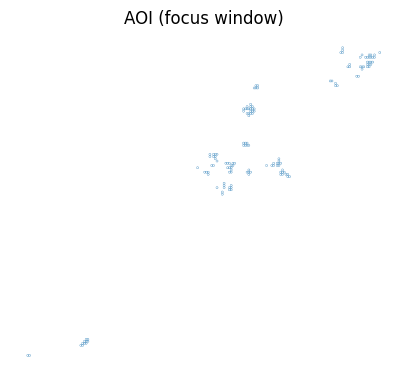

In [5]:
# -------------     Build Area of Interest (AOI) - Focus Window     ------------------

# Convert all roadkill points to lat/lon coordinates

all_points = road_kill_gdf.to_crs(CRS_LONLAT).copy()

# Round coordinates to create spatial tiles (~11 km resolution)

all_points["lat_round"] = np.round(all_points.geometry.y / ROUND_DEG) * ROUND_DEG
all_points["lon_round"] = np.round(all_points.geometry.x / ROUND_DEG) * ROUND_DEG

# Extract unique tile centroids (one point per tile)

tiles = all_points[["lat_round","lon_round"]].drop_duplicates()
tile_points = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(tiles["lon_round"], tiles["lat_round"]),
    crs=CRS_LONLAT
).to_crs(CRS_METRIC)


# Create GeoDataFrame of tile centroids and convert to metric CRS

AOI = tile_points.buffer(FOCUS_BUF_M).union_all()
AOI_gdf = gpd.GeoDataFrame(geometry=[AOI], crs=CRS_METRIC)

# Buffer each tile centroid by 1 km and dissolve into single polygon
# union_all() merges overlapping buffers into one continuous AOI

print("[AOI] Focus window built (1 km around occupied tiles)")
AOI_gdf.boundary.plot(figsize=(5,5))
plt.title("AOI (focus window)")
plt.axis("off")
plt.show()


### 1.3 OSM roads inside the focus-window (tile-based)

**Aim**

-   Extract drivable road network data from OpenStreetMap (OSM) within the Area of Interest (AOI) to serve as the spatial framework for collision risk analysis.

**Road Classification**:

- Filtering only to major road types: `motorway`, `trunk`, `primary`, `secondary`, `tertiary`, `residential`
- These show the road hierarchy where most vehicle-wildlife collisions occur. 

**Data Quality**:
- I have noticed that it is common to have missing OSM tags. 
- Fill the missing values with defaults based on road class. 
- Clip the final roads to AOI boundary to remove edge artifacts from tile downloads. 

In [6]:
#   -------     Download OSM Road Network (Tile-Based)  ----------

roads_list = []

# Iterating through each unique tile (from AOI creation step)

for _, row in tiles.iterrows():
    lat, lon = row["lat_round"], row["lon_round"]
    try:
        G = ox.graph_from_point((lat, lon), dist=OSM_TILE_DIST_M, network_type="drive")
        gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)
        roads_list.append(gdf)
    except Exception as e:
        continue

roads = gpd.GeoDataFrame(pd.concat(roads_list, ignore_index=True), crs=CRS_LONLAT).to_crs(CRS_METRIC)

for col in ["highway","maxspeed","lanes","oneway","surface","bridge","tunnel"]:
    if col not in roads.columns:
        roads[col] = np.nan

def norm_highway(v):
    return v[0] if isinstance(v, list) else v

roads["highway_norm"] = roads["highway"].apply(norm_highway)
valid_classes = {"motorway","trunk","primary","secondary","tertiary","residential"}

roads = roads[roads["highway_norm"].isin(valid_classes)].copy()

# clip to AOI to drop margins
roads = gpd.overlay(roads, AOI_gdf, how="intersection")

# explode and clean
roads = roads.explode(index_parts=False, ignore_index=True)
roads = roads[~roads.geometry.is_empty & roads.geometry.notna()].copy()

print(f"[OSM] roads in AOI: {len(roads)}")
roads.sample(min(3, len(roads)))


[OSM] roads in AOI: 3081


,osmid,highway,lanes,maxspeed,name,oneway,ref,reversed,length,junction,bridge,tunnel,access,width,est_width,service,surface,highway_norm,geometry
63,88637472,tertiary,NaN,NaN,Calle Siles,False,NaN,False,219.111468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tertiary,"LINESTRING (-488848 4452776.49, -488866.902 44..."
1922,202398743,residential,NaN,NaN,NaN,False,NaN,True,9.882719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential,"LINESTRING (-1502121.264 3375622.043, -1502112..."
2019,1368769439,residential,NaN,NaN,NaN,True,NaN,False,16.540635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential,"LINESTRING (-1503633.15 3375595.455, -1503628...."


In [11]:
roads.to_file("roads.gpkg", driver="GPKG")

####    Handle missing OSM tags with safe defaults (helps later):

In [7]:
# Default by highway class (tuned to Spanish norms)

DEFAULT_SPEED = {"motorway":120, "trunk":100, "primary":90, "secondary":80, "tertiary":60, "residential":30}
DEFAULT_LANES = {"motorway":2, "trunk":2, "primary":2, "secondary":1, "tertiary":1, "residential":1}

def parse_speed(x, cls):
    if isinstance(x, list) and len(x): x = x[0]
    if isinstance(x, str):
        num = "".join(ch for ch in x if ch.isdigit())
        x = int(num) if num else np.nan
    try:
        v = int(x)
        return v if 10 <= v <= 140 else DEFAULT_SPEED.get(cls, 50)
    except:
        return DEFAULT_SPEED.get(cls, 50)

def parse_lanes(x, cls):
    if isinstance(x, list) and len(x): x = x[0]
    try:
        v = int(x)
        return v if 1 <= v <= 6 else DEFAULT_LANES.get(cls, 1)
    except:
        return DEFAULT_LANES.get(cls, 1)

roads["maxspeed_kph"] = [parse_speed(x, c) for x, c in zip(roads["maxspeed"], roads["highway_norm"])]
roads["n_lanes"]      = [parse_lanes(x, c) for x, c in zip(roads["lanes"], roads["highway_norm"])]
roads["is_oneway"]    = roads["oneway"].astype("bool").fillna(False)


### 1.4 Segment Roads into 500 m Chunks

**Aim**
- Divide road network into uniform -500 m segments to create consistent analysis units for collision risk modeling.

**Why do we segment**
- It provides a fair comparison across different road types and identifies high-risk segments within longer roads. 

**Segment Features Calculated**:
-   segment_length_m (Actual measured length of each segment)
-   curve_index (Road curvature measure) : Higher values indicate sharper curves indicating potential collision hotspots. 
-   interaction_density (Count of nearby road endpoints per kilometer) : Gives insights into animal movement. 



In [8]:
def segment_line(line: LineString, target_m=SEG_TARGET_M):
    """
    Split a LineString into segments of approximately target_m length.
    """
    
    # It handles non-LineString geometries
    
    if not isinstance(line, LineString): 
        return []
    
    # If line is already shorter than target, return as-is
    if line.length <= target_m: 
        return [line]
    
    # Calculate number of segments needed
    n = int(np.ceil(line.length / target_m))
    dists = [i * line.length / n for i in range(1, n)]
    
    # Split line at each distance point
    pieces = [line]
    for d in dists:
        p = line.interpolate(d)
        tiny = p.buffer(0.05)
        new_pieces = []
        for seg in pieces:
            try:
                parts = split(seg, tiny)
                new_pieces.extend([g for g in parts.geoms if isinstance(g, LineString)])
            except Exception:
                new_pieces.append(seg)
        pieces = new_pieces
    return [s for s in pieces if s.length > 1]

# build segments table

seg_rows, sid = [], 0
for _, r in tqdm(roads.iterrows(), total=len(roads), desc="Segmenting"):
    for seg in segment_line(r.geometry):
        seg_rows.append({
            "segment_id": sid,
            "geometry": seg,
            "highway_norm": r["highway_norm"],
            "maxspeed_kph": r["maxspeed_kph"],
            "n_lanes": r["n_lanes"],
            "is_oneway": r["is_oneway"],
            "surface": r["surface"],
            "bridge": r["bridge"],
            "tunnel": r["tunnel"],
        })
        sid += 1

segments = gpd.GeoDataFrame(seg_rows, crs=roads.crs)
segments["segment_length_m"] = segments.geometry.length

# curvature proxy (bearing change per meter)

def curve_index(line: LineString, step=20):
    L = line.length
    if L < 2*step: return 0.0
    d = np.arange(0, L, step)
    pts = [line.interpolate(x) for x in d] + [line.interpolate(L)]
    bearings = []
    for p0, p1 in zip(pts[:-1], pts[1:]):
        dx, dy = (p1.x - p0.x), (p1.y - p0.y)
        bearings.append(np.degrees(np.arctan2(dy, dx)))
    diffs = np.abs(np.diff(bearings))
    diffs = np.minimum(diffs, 360 - diffs)
    return float(diffs.sum() / max(L, 1))

segments["curve_index"] = segments.geometry.apply(curve_index)

# intersection density: count endpoints within radius per km

endpoints = []
for g in segments.geometry:
    xs, ys = g.coords.xy
    endpoints.append(Point(xs[0], ys[0]))
    endpoints.append(Point(xs[-1], ys[-1]))
end_gdf = gpd.GeoDataFrame(geometry=endpoints, crs=segments.crs)

midpts = segments.geometry.interpolate(0.5, normalized=True)
mid_gdf = gpd.GeoDataFrame(segments[["segment_id"]], geometry=midpts, crs=segments.crs)

# buffer once, spatial join

near = gpd.sjoin(
    end_gdf,
    gpd.GeoDataFrame(geometry=mid_gdf.buffer(INTERSECT_NEAR_M), crs=segments.crs),
    how="left", predicate="within"
)

counts = near.groupby(near.index_right).size()
segments["intersection_density"] = counts.reindex(range(len(segments))).fillna(0).values / (segments["segment_length_m"]/1000 + 1e-6)

print(f"[Segments] built: {len(segments)}")
segments.head(2)


Segmenting: 100%|██████████| 3081/3081 [00:00<00:00, 18945.86it/s]


[Segments] built: 3352


,segment_id,geometry,highway_norm,maxspeed_kph,n_lanes,is_oneway,surface,bridge,tunnel,segment_length_m,curve_index,intersection_density
0,0,"LINESTRING (-700885.791 4494106.34, -701317.43...",secondary,90,2,False,NaN,NaN,NaN,431.64759,1.009614e-10,13.900196
1,1,"LINESTRING (-701317.533 4494108.559, -701352.3...",secondary,90,2,False,NaN,NaN,NaN,431.64759,4.679513e-07,13.900196


### 1.5 Label creation (nearest-segment match ≤ 200 m)

**Aim**
- Create the binary labels (collision_risk) by matching roadkill observations to nearest road segments.

**Method:**

-   Use a nearest-neighbor spatial join with a 200 m maximum distance to handle GBIF GPS uncertainty.
-   A segment is positive (1) if ≥1 collision falls within 200 m; otherwise negative (0).

**Label Outputs:**

-   collision_count: Number of matched collisions
-   collision_risk: 1 if collision_count > 0, else 0

**Why 200 m?**

-   Roadkill often recorded slightly off-road.
-   200 m provides good precision–recall balance and sensitivity tests show little gain beyond this distance.


In [9]:
# ensure both in same CRS
assert road_kill_gdf.crs == segments.crs == CRS_METRIC

# nearest join (fast with sindex). geopandas>=0.10 has sjoin_nearest
joined = gpd.sjoin_nearest(
    road_kill_gdf[["gbifID","eventDate","geometry"]],
    segments[["segment_id","geometry"]],
    how="inner", 
    max_distance=MATCH_MAX_M, 
    distance_col="dist_m"
)

# aggregate counts per segment
counts = joined.groupby("segment_id").size().rename("collision_count")
segments = segments.join(counts, on="segment_id")
segments["collision_count"] = segments["collision_count"].fillna(0).astype(int)
segments["collision_risk"]  = (segments["collision_count"] > 0).astype(int)


## **Part 2: Predictive Modelling**

### 2.1 Data Preparation

-   Prepare data for modeling by extracting features and target.

In [ ]:
def prepare_modeling_data(segments, target_col="collision_risk"):
    
    numerical_cols = [
        "segment_length_m", "curve_index", "intersection_density",
        "maxspeed_kph", "n_lanes"
    ]
    
    categorical_cols = ["highway_norm", "is_oneway", "surface", "bridge", "tunnel"]
    
    df = segments.drop(columns=["geometry", "buffer_geom"], errors="ignore").copy()
    df[target_col] = df[target_col].astype(int)
    
    # Handle categorical columns (convert lists to strings)
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: x[0] if isinstance(x, list) else x)
            df[col] = df[col].astype(str)
    
    X = df[numerical_cols + categorical_cols]
    y = df[target_col].values
    
    feature_info = {"numerical": numerical_cols, "categorical": categorical_cols}
    return X, y, feature_info


X, y, feature_info = prepare_modeling_data(segments)
numerical_cols = feature_info["numerical"]
categorical_cols = feature_info["categorical"]

print(f"Dataset shape: {X.shape}, positives: {y.sum()} ({y.mean():.2%})")

Dataset shape: (3352, 10), positives: 52 (1.55%)


### 2.2     Build Preprocessing Pipeline

In [ ]:
def build_preprocessor(numerical_cols, categorical_cols):
    """
    Build preprocessing pipeline for numerical and categorical features.
    """
    
    # Median imputation for numerical
    numeric_tf = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])
    
    # mode for categorical
    categorical_tf = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_tf, numerical_cols),
            ("cat", categorical_tf, categorical_cols),
        ]
    )
    return preprocessor

preprocessor = build_preprocessor(numerical_cols, categorical_cols)

### 2.3 Helper Functions: Class Imbalance

In [36]:
def calculate_imbalance_ratio(y):
    """Calculate class imbalance ratio (negative:positive)."""
    
    # Calculate class imbalance ratio (negative:positive).
    # This ratio is used for XGBoost's scale_pos_weight parameter
    
    n_neg = (y == 0).sum()
    n_pos = (y == 1).sum()
    return n_neg / n_pos if n_pos > 0 else 0

imbalance_ratio = calculate_imbalance_ratio(y)
print(f"Class imbalance ratio: {imbalance_ratio:.1f}:1")


Class imbalance ratio: 63.5:1


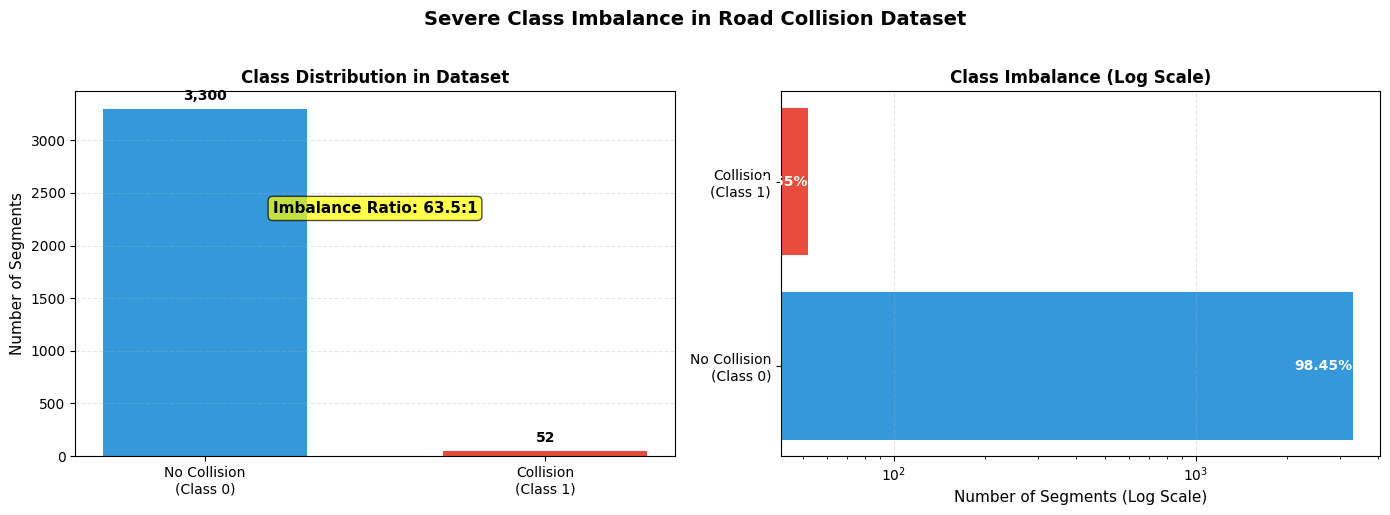

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Bar chart with counts
class_counts = pd.Series(y).value_counts().sort_index()
bars = axes[0].bar(['No Collision\n(Class 0)', 'Collision\n(Class 1)'], 
                   class_counts.values, 
                   color=['#3498db', '#e74c3c'], width=0.6)
axes[0].set_ylabel('Number of Segments', fontsize=11)
axes[0].set_title('Class Distribution in Dataset', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, class_counts.values)):
    axes[0].text(bar.get_x() + bar.get_width()/2, count + 50, 
                f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Add imbalance ratio annotation
imbalance_ratio = calculate_imbalance_ratio(y)
axes[0].text(0.5, max(class_counts.values) * 0.7, 
             f'Imbalance Ratio: {imbalance_ratio:.1f}:1', 
             ha='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Right: Log-scale comparison (shows the severity)
axes[1].barh(['No Collision\n(Class 0)', 'Collision\n(Class 1)'], 
             class_counts.values, color=['#3498db', '#e74c3c'])
axes[1].set_xlabel('Number of Segments (Log Scale)', fontsize=11)
axes[1].set_title('Class Imbalance (Log Scale)', fontsize=12, fontweight='bold')
axes[1].set_xscale('log')
axes[1].grid(axis='x', alpha=0.3, linestyle='--')

# Add percentage labels
total = len(y)
pct_0 = (class_counts[0] / total) * 100
pct_1 = (class_counts[1] / total) * 100
axes[1].text(class_counts[0], 0, f'{pct_0:.2f}%', 
            ha='right', va='center', fontweight='bold', color='white')
axes[1].text(class_counts[1], 1, f'{pct_1:.2f}%', 
            ha='right', va='center', fontweight='bold', color='white')

plt.suptitle('Severe Class Imbalance in Road Collision Dataset', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 2.4 Building the models 

In [ ]:
def build_models(preprocessor, y, random_state=42):
    
    """
    Build all models (Logistic Regression, Random Forest, Decision Tree, XGBoost) with two strategies:
    - 1. class_weight
    - 2. oversampling strategy
    """
    
    models = {}
    scale_pos_weight = calculate_imbalance_ratio(y)
    
    oversampler = RandomOverSampler(
        random_state=random_state,
        sampling_strategy=1.0
    )

    def add_model_pair(name, estimator_class, base_params,
                       use_class_weight=False, is_xgb=False):
        """
        Add two variants for a given estimator:
        - {name}_class_weight
        - {name}_oversample
        """
        
        # --- Class weight / scale_pos_weight variant ---
        
        params_cw = base_params.copy()
        if use_class_weight and not is_xgb:
            params_cw["class_weight"] = "balanced"
        if is_xgb:
            params_cw["scale_pos_weight"] = scale_pos_weight
        
        clf_cw = estimator_class(**params_cw)
        models[f"{name}_class_weight"] = Pipeline(steps=[
            ("prep", preprocessor),
            ("clf", clf_cw)
        ])
        
        # --- Oversample the variant ---
        
        params_os = base_params.copy()
        if use_class_weight and not is_xgb:
            params_os["class_weight"] = "balanced"
        if is_xgb:
            # after oversampling, classes are balanced
            params_os["scale_pos_weight"] = 1.0
        
        clf_os = estimator_class(**params_os)
        models[f"{name}_oversample"] = ImbPipeline(steps=[
            ("prep", preprocessor),
            ("oversample", oversampler),
            ("clf", clf_os)
        ])
    
    # Logistic Regression
    add_model_pair(
        name="logreg",
        estimator_class=LogisticRegression,
        base_params=dict(
            max_iter=2000,
            solver="lbfgs",
            C=0.1,
            random_state=random_state
        ),
        use_class_weight=True,
        is_xgb=False
    )
    
    # Random Forest
    add_model_pair(
        name="rf",
        estimator_class=RandomForestClassifier,
        base_params=dict(
            n_estimators=200,
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            random_state=random_state,
            n_jobs=-1
        ),
        use_class_weight=True,
        is_xgb=False
    )
    
    # Decision Tree
    add_model_pair(
        name="dt",
        estimator_class=DecisionTreeClassifier,
        base_params=dict(
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            random_state=random_state
        ),
        use_class_weight=True,
        is_xgb=False
    )
    
    # XGBoost
    add_model_pair(
        name="xgb",
        estimator_class=XGBClassifier,
        base_params=dict(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=5,
            eval_metric="logloss",
            random_state=random_state,
            n_jobs=-1,
            verbosity=0
        ),
        use_class_weight=False,
        is_xgb=True
    )
    
    return models


# Build all models 

all_models = build_models(preprocessor, y, RANDOM_SEED)
print(f"Built {len(all_models)} models")



Built 8 models


##  **Part 3 — Model Evaluation**

### 3.1 Cross-Validation Evaluation

In [28]:
def evaluate_models_cv(models, X, y, n_splits=5, random_state=42):
    """
    Evaluate models using stratified k-fold cross-validation.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rows = []
    
    for name, pipe in models.items():
        rocs, prs, f1s = [], [], []
        for tr_idx, te_idx in skf.split(X, y):
            X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
            y_tr, y_te = y[tr_idx], y[te_idx]
            
            pipe.fit(X_tr, y_tr)
            y_prob = pipe.predict_proba(X_te)[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)
            
            rocs.append(roc_auc_score(y_te, y_prob))
            prs.append(average_precision_score(y_te, y_prob))
            f1s.append(f1_score(y_te, y_pred))
        
        rows.append({
            "model": name,
            "pr_auc_mean": np.mean(prs),
            "pr_auc_std": np.std(prs),
            "roc_auc_mean": np.mean(rocs),
            "roc_auc_std": np.std(rocs),
            "f1_mean": np.mean(f1s),
            "f1_std": np.std(f1s),
        })
    
    res = pd.DataFrame(rows).sort_values("pr_auc_mean", ascending=False).reset_index(drop=True)
    return res

cv_results = evaluate_models_cv(all_models, X, y, n_splits=5, random_state=RANDOM_SEED)

print()
print("Cross-Validation Results: filtered by their PR-AUC ")
print()
display(cv_results.style.format({
    "pr_auc_mean": "{:.3f}", "pr_auc_std": "{:.3f}",
    "roc_auc_mean": "{:.3f}", "roc_auc_std": "{:.3f}",
    "f1_mean": "{:.3f}", "f1_std": "{:.3f}"
}))

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Cross-Validation Results: filtered by their PR-AUC 



,model,pr_auc_mean,pr_auc_std,roc_auc_mean,roc_auc_std,f1_mean,f1_std
0,xgb_class_weight,0.818,0.091,0.977,0.033,0.756,0.081
1,xgb_oversample,0.778,0.100,0.972,0.035,0.736,0.089
2,rf_oversample,0.659,0.090,0.972,0.031,0.533,0.060
3,rf_class_weight,0.545,0.093,0.972,0.021,0.490,0.082
4,dt_oversample,0.423,0.094,0.924,0.089,0.442,0.073
5,dt_class_weight,0.344,0.088,0.915,0.070,0.319,0.049
6,logreg_class_weight,0.151,0.062,0.890,0.037,0.134,0.021
7,logreg_oversample,0.120,0.043,0.889,0.034,0.131,0.022


####    Summary of cross-validation results: 

- XGBoost with class weighting (xgb_class_weight) performs best by PR‑AUC: 0.818 ± 0.091, with very high ROC‑AUC (0.977) and the highest F1 (0.756).

- XGBoost with oversampling is the second best (PR‑AUC 0.778), indicating both imbalance‑aware weighting and oversampling help but weighting worked best here.

- Random forest benefits from oversampling (PR‑AUC 0.659 vs 0.545 for class_weight); decision tree and logistic regression perform substantially worse.

Why PR-AUC? 
- ROC‑AUC is uniformly high across models (=0.89–0.98) and in PR‑AUC differentiates models better on this imbalanced task,  PR‑AUC was used to rank models appropriately.

### 3.2     Choose the best performing model

In [30]:
def select_best_model(cv_results, models):
    """
    Select best model based on PR-AUC score.
    """
    best_model_name = cv_results.iloc[0]["model"]
    best_model = models[best_model_name]
    print(f"\nBest model: {best_model_name}")
    print(f"  PR-AUC: {cv_results.iloc[0]['pr_auc_mean']:.3f} ± {cv_results.iloc[0]['pr_auc_std']:.3f}")
    print(f"  ROC-AUC: {cv_results.iloc[0]['roc_auc_mean']:.3f} ± {cv_results.iloc[0]['roc_auc_std']:.3f}")
    print(f"  F1: {cv_results.iloc[0]['f1_mean']:.3f} ± {cv_results.iloc[0]['f1_std']:.3f}")

    return best_model_name, best_model

best_model_name, best_model = select_best_model(cv_results, all_models)


Best model: xgb_class_weight
  PR-AUC: 0.818 ± 0.091
  ROC-AUC: 0.977 ± 0.033
  F1: 0.756 ± 0.081


###     3.3 Final Train & Test Eval

In [29]:
def final_evaluation(model, X, y, test_size=0.2, random_state=42):
    """
    Final evaluation using train/test split.
    """
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import (
        roc_auc_score, average_precision_score, f1_score,
        confusion_matrix, classification_report
    )
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"Training set: {len(X_train)} samples ({y_train.sum()} positives, {y_train.mean():.2%})")
    print(f"Test set: {len(X_test)} samples ({y_test.sum()} positives, {y_test.mean():.2%})")
    
    model.fit(X_train, y_train)
    
    y_test_proba = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_proba >= 0.5).astype(int)
    
    metrics = {
        "roc_auc": roc_auc_score(y_test, y_test_proba),
        "pr_auc": average_precision_score(y_test, y_test_proba),
        "f1": f1_score(y_test, y_test_pred),
        "confusion_matrix": confusion_matrix(y_test, y_test_pred),
        "classification_report": classification_report(y_test, y_test_pred)
    }
    
    print()
    print("Final model performance (test set)")
    print()
    print(f"ROC-AUC Score: {metrics['roc_auc']:.4f}")
    print(f"PR-AUC Score:  {metrics['pr_auc']:.4f}")
    print(f"F1 Score:       {metrics['f1']:.4f}")
    print("\nConfusion Matrix:")
    print(metrics['confusion_matrix'])
    print("\nClassification Report:")
    print(metrics['classification_report'])
    
    return {
        "model": model,
        "X_test": X_test,
        "y_test": y_test,
        "y_test_proba": y_test_proba,
        "y_test_pred": y_test_pred,
        "metrics": metrics
    }


final_results = final_evaluation(best_model, X, y, test_size=0.2, random_state=RANDOM_SEED)

Training set: 2681 samples (42 positives, 1.57%)
Test set: 671 samples (10 positives, 1.49%)

Final model performance (test set)

ROC-AUC Score: 0.9899
PR-AUC Score:  0.4983
F1 Score:       0.5000

Confusion Matrix:
[[653   8]
 [  4   6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       661
           1       0.43      0.60      0.50        10

    accuracy                           0.98       671
   macro avg       0.71      0.79      0.75       671
weighted avg       0.99      0.98      0.98       671



### 3.4 Generate Predictions and output the final segments with predictions


In [35]:
def generate_predictions(model, X, segments):
    """
    Generate predictions for full dataset and add to segments GeoDataFrame.
    """
    model.fit(X, y)
    
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)
    
    segments = segments.copy()
    segments["collision_probability"] = y_proba
    segments["predicted_risk"] = y_pred
    
    segments["risk_category"] = pd.cut(
        segments["collision_probability"],
        bins=[0, 0.1, 0.3, 0.5, 1.0],
        labels=["Low", "Medium", "High", "Very High"]
    )
    
    print(" Model trained and predictions generated: ")
    print("------------------------------------------")
    print(f"   Predicted high-risk segments: {(segments['predicted_risk'] == 1).sum()}")
    print(f"   Average collision probability: {segments['collision_probability'].mean():.3f}")
    print("------------------------------------------")
    print("   Risk distribution:")
    print(segments["risk_category"].value_counts().sort_index())
    
    return segments


segments = generate_predictions(best_model, X, segments)

 Model trained and predictions generated: 
------------------------------------------
   Predicted high-risk segments: 66
   Average collision probability: 0.025
------------------------------------------
   Risk distribution:
risk_category
Low          3227
Medium         56
High            3
Very High      66
Name: count, dtype: int64


### Model-based risk map – Key notes 

- After training the best model on all segments, I fetched segment-level collision probabilities, collision_probability and a binary risk label predicted_risk. 

- I further categorized probabilities into **risk categories**:

  - Low: 0–0.10 → 3,227 segments  
  - Medium: 0.10–0.30 → 56 segments  
  - High: 0.30–0.50 → 3 segments  
  - Very High: 0.50–1.00 → 66 segments

- Only **66 of 3,326 segments (2%)** are classified as *very high risk*, consistent with the overall rarity of collisions (average predicted probability ≈ **2.5%**).

- These predictions turn the model into a **practical risk map**: each road segment can be visualised on a map by risk category, highlighting potential hotspots.

- The risk categories provide an interpretable output for **decision-makers**, e.g.,  

  - prioritising mitigation (signs, fencing, monitoring) on *Very High* segments,  
  - and reviewing *Medium* segments as secondary candidates.
